# Courts Data Analysis

This notebook loads court data from courts.yaml and processes it into a structured dataframe.


In [10]:
%pip install pandas
%pip install pathlib
%pip install matplotlib


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 6.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.9/113.9 KB 2.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 5.7 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 2.2 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 2.3 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.9 MB/s eta 0:00:00:00:010:01m
Note: you may need to restart the kernel to use updated packages.


In [3]:
import yaml
import pandas as pd
from pathlib import Path


In [5]:
# Load the YAML file
yaml_path = Path('../src/assets/courts.yaml')
with open(yaml_path, 'r', encoding='utf-8') as f:
    courts_data = yaml.safe_load(f)

print(f"Loaded {len(courts_data)} clubs")


Loaded 22 clubs


In [6]:
# Process the data into a flat structure
rows = []

for club in courts_data:
    club_name = club.get('name')
    club_id = club.get('id')

    # Iterate through court types
    for court in club.get('courts', []):
        surface = court.get('surface')
        court_type = court.get('type')

        # Iterate through pricing periods
        for price_period in court.get('prices', []):
            period_from = price_period.get('from')
            schedule = price_period.get('schedule', {})

            # Extract all prices from the schedule
            if schedule:
                prices = []
                for time_slot, price in schedule.items():
                    if price is not None:
                        # Convert to float/int if it's a string
                        try:
                            price_value = float(price) if isinstance(price, (str, int, float)) else None
                            if price_value is not None:
                                prices.append(price_value)
                        except (ValueError, TypeError):
                            pass

                # Calculate min and max prices
                min_price = min(prices) if prices else None
                max_price = max(prices) if prices else None
            else:
                min_price = None
                max_price = None

            rows.append({
                'club_name': club_name,
                'club_id': club_id,
                'surface': surface,
                'type': court_type,
                'period_from': period_from,
                'min_price': min_price,
                'max_price': max_price
            })

# Create dataframe
df = pd.DataFrame(rows)

print(f"Created dataframe with {len(df)} rows")
df.head(10)


Created dataframe with 127 rows


,club_name,club_id,surface,type,period_from,min_price,max_price
0,Matchpoint Wrocław,matchpoint,hard,indoor,2024-05-01,50.0,80.0
1,Matchpoint Wrocław,matchpoint,hard,indoor,2024-10-01,110.0,170.0
2,Matchpoint Wrocław,matchpoint,hard,indoor,2025-05-01,50.0,80.0
3,Matchpoint Wrocław,matchpoint,hard,indoor,2025-10-01,115.0,175.0
4,Matchpoint Wrocław,matchpoint,hard,tent,2024-11-01,130.0,160.0
5,Matchpoint Wrocław,matchpoint,hard,tent,2025-05-01,50.0,80.0
6,Matchpoint Wrocław,matchpoint,hard,tent,2025-10-01,135.0,165.0
7,Krzycka Park,krzycka-park,clay,outdoor,2024-05-01,40.0,50.0
8,Krzycka Park,krzycka-park,clay,outdoor,2024-11-01,NaN,NaN
9,Krzycka Park,krzycka-park,clay,outdoor,2025-05-01,45.0,55.0


In [15]:
# Add season+year column
def get_season_year(date_str):
    """
    Determine season and year based on the date.
    Winter: October-March (uses year from Oct-Dec, previous year for Jan-Mar)
    Summer: April-September
    """
    if date_str is None or pd.isna(date_str):
        return None

    try:
        date = pd.to_datetime(date_str)
        month = date.month
        year = date.year

        # Winter months: Oct(10), Nov(11), Dec(12), Jan(1), Feb(2), Mar(3)
        if month in [10, 11, 12]:
            return f'winter-{year}'
        elif month in [1, 2, 3]:
            return f'winter-{year - 1}'
        # Summer months: Apr(4), May(5), Jun(6), Jul(7), Aug(8), Sep(9)
        else:
            return f'summer-{year}'
    except:
        return None

df['season'] = df['period_from'].apply(get_season_year)

# Display the updated dataframe
print(f"Added season_year column")
df[['club_name', 'period_from', 'season', 'min_price', 'max_price']].head(15)


Added season_year column


,club_name,period_from,season,min_price,max_price
0,Matchpoint Wrocław,2024-05-01,summer-2024,50.0,80.0
1,Matchpoint Wrocław,2024-10-01,winter-2024,110.0,170.0
2,Matchpoint Wrocław,2025-05-01,summer-2025,50.0,80.0
3,Matchpoint Wrocław,2025-10-01,winter-2025,115.0,175.0
4,Matchpoint Wrocław,2024-11-01,winter-2024,130.0,160.0
5,Matchpoint Wrocław,2025-05-01,summer-2025,50.0,80.0
6,Matchpoint Wrocław,2025-10-01,winter-2025,135.0,165.0
7,Krzycka Park,2024-05-01,summer-2024,40.0,50.0
8,Krzycka Park,2024-11-01,winter-2024,NaN,NaN
9,Krzycka Park,2025-05-01,summer-2025,45.0,55.0


In [ ]:
# Display basic statistics
df.info()


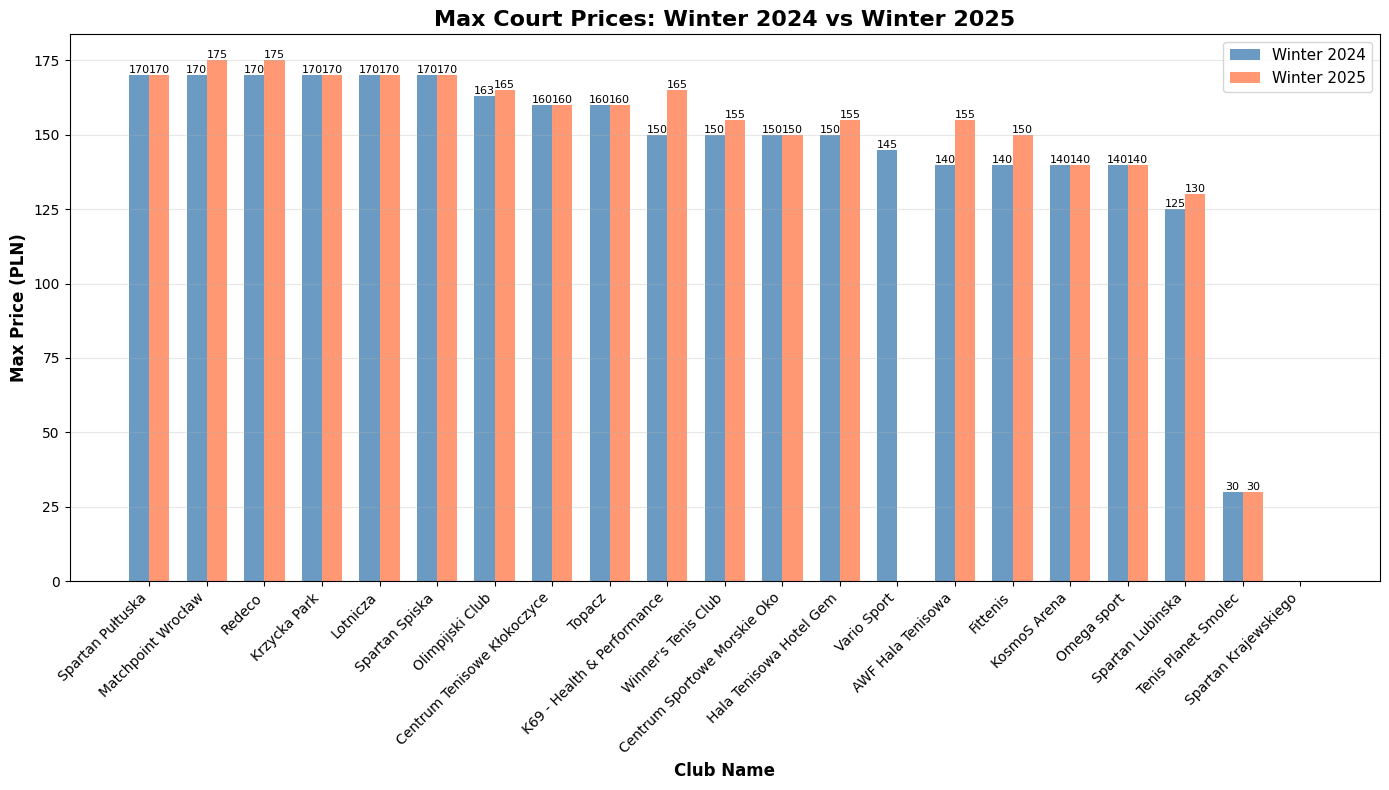


Price comparison table:
season                        winter-2024  winter-2025  change  change_pct
club_name                                                                 
Spartan Pułtuska                    170.0        170.0     0.0         0.0
Matchpoint Wrocław                  170.0        175.0     5.0         2.9
Redeco                              170.0        175.0     5.0         2.9
Krzycka Park                        170.0        170.0     0.0         0.0
Lotnicza                            170.0        170.0     0.0         0.0
Spartan Spiska                      170.0        170.0     0.0         0.0
Olimpijski Club                     163.0        165.0     2.0         1.2
Centrum Tenisowe Kłokoczyce         160.0        160.0     0.0         0.0
Topacz                              160.0        160.0     0.0         0.0
K69 - Health & Performance          150.0        165.0    15.0        10.0
Winner's Tenis Club                 150.0        155.0     5.0         3.3


In [16]:
# Bar chart comparing winter-2024 vs winter-2025 max prices by club
import numpy as np

# Filter data for winter-2024 and winter-2025
df_winter = df[df['season'].isin(['winter-2024', 'winter-2025'])].copy()

# Get max price for each club and season
df_comparison = df_winter.groupby(['club_name', 'season'])['max_price'].max().reset_index()

# Pivot to get winter-2024 and winter-2025 as separate columns
df_pivot = df_comparison.pivot(index='club_name', columns='season', values='max_price').fillna(0)

# Sort by winter-2024 prices for better visualization
df_pivot = df_pivot.sort_values('winter-2024', ascending=False)

# Create bar chart
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(df_pivot.index))
width = 0.35

# Create bars
bars1 = ax.bar(x - width/2, df_pivot['winter-2024'], width, label='Winter 2024', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, df_pivot['winter-2025'], width, label='Winter 2025', alpha=0.8, color='coral')

# Customize chart
ax.set_xlabel('Club Name', fontsize=12, fontweight='bold')
ax.set_ylabel('Max Price (PLN)', fontsize=12, fontweight='bold')
ax.set_title('Max Court Prices: Winter 2024 vs Winter 2025', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(df_pivot.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}',
                   ha='center', va='bottom', fontsize=8)

add_value_labels(bars1)
add_value_labels(bars2)

plt.tight_layout()
plt.show()

# Show comparison table
print("\nPrice comparison table:")
df_pivot_display = df_pivot.copy()
df_pivot_display['change'] = df_pivot['winter-2025'] - df_pivot['winter-2024']
df_pivot_display['change_pct'] = ((df_pivot['winter-2025'] - df_pivot['winter-2024']) / df_pivot['winter-2024'] * 100).round(1)
print(df_pivot_display.to_string())
